#  Real world dataset
## Sampling rate = 10Hz
## Window size = 4 seconds
This dataset includes the following:
    Right turn = 30
    Left turn  = 30
    Acceleration = 30
    Braking = 30

## Procedures

## 1. Import libraries

In [45]:
%config IPCompleter.greedy=True  ##enable intellisense
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense, Dropout, BatchNormalization, MaxPooling1D
from tensorflow.keras.layers import Conv2D,Conv1D, MaxPool2D, MaxPool1D
from tensorflow.keras.optimizers import Adam
print(tf.__version__)

2.4.1


## 2. Import supporting libraries

In [46]:
import pandas as pd  ## used to read datasets
import numpy as np   ## to do basic array operations
import sqlite3   ## working with sqlite3 data
import matplotlib.pyplot as plt   ## to visualize the results
from sklearn.model_selection import train_test_split   ## to split the data into training and testing
from sklearn.preprocessing import StandardScaler, LabelEncoder


## 3. Import dataset (SQLite format)

In [47]:
file = open('TESTDATA_real.db')  ## open the file and put in variable 'file'

conn = sqlite3.connect('TESTDATA_real.db')   ## create a cursor pointing to the dataset

data = pd.read_sql_query('SELECT * FROM SENSOR_TABLE', conn)  ##create a pandas dataframe

data.insert(0, 'unit', range(1, 1+len(data)))  ## add units to make it easier identify
data.head()

,unit,TIME,ACCEL_X,ACCEL_Y,ACCEL_Z,GYRO_X,GYRO_Y,GYRO_Z,CURRENT_SPEED,ACTIVITY
0,1,09:54:08,0.028730,9.651326,-0.098162,-0.001145,0.001833,0.000611,0.0,Right
1,2,09:54:08,0.028730,9.651326,-0.098162,-0.001145,0.001833,0.000611,0.0,Right
2,3,09:54:08,0.122104,9.646538,-0.663194,-0.001145,0.000000,-0.000611,0.0,Right
3,4,09:54:08,0.122104,9.646538,-0.663194,-0.001145,0.000000,-0.000611,0.0,Right
4,5,09:54:08,0.112527,9.639356,-0.962469,-0.001145,0.000000,-0.000611,0.0,Right


In [48]:
data.shape   ## observe the size of data we're working with

(6448, 10)

In [49]:
data.info()   ##show the forms of data we have in each column

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6448 entries, 0 to 6447
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   unit           6448 non-null   int32  
 1   TIME           6448 non-null   object 
 2   ACCEL_X        6448 non-null   float64
 3   ACCEL_Y        6448 non-null   float64
 4   ACCEL_Z        6448 non-null   float64
 5   GYRO_X         6448 non-null   float64
 6   GYRO_Y         6448 non-null   float64
 7   GYRO_Z         6448 non-null   float64
 8   CURRENT_SPEED  6448 non-null   float64
 9   ACTIVITY       6448 non-null   object 
dtypes: float64(7), int32(1), object(2)
memory usage: 478.7+ KB


In [50]:
data.shape

(6448, 10)

In [51]:
data.tail()

,unit,TIME,ACCEL_X,ACCEL_Y,ACCEL_Z,GYRO_X,GYRO_Y,GYRO_Z,CURRENT_SPEED,ACTIVITY
6443,6444,10:18:39,0.251391,9.988909,0.172383,0.010461,0.000611,0.000000,0.0,Brake
6444,6445,10:18:39,0.263362,9.890746,-0.387861,-0.009697,0.000000,-0.000611,0.0,Brake
6445,6446,10:18:39,0.263362,9.890746,-0.387861,-0.009697,0.000000,-0.000611,0.0,Brake
6446,6447,10:18:39,0.014365,9.522039,-1.103727,0.004963,0.000611,0.000000,0.0,Brake
6447,6448,10:18:39,0.014365,9.522039,-1.103727,0.004963,0.000611,0.000000,0.0,Brake


### 3.1 Checking for null values

In [52]:
data.isnull().sum()  ## sum the NULL values together

unit             0
TIME             0
ACCEL_X          0
ACCEL_Y          0
ACCEL_Z          0
GYRO_X           0
GYRO_Y           0
GYRO_Z           0
CURRENT_SPEED    0
ACTIVITY         0
dtype: int64

In [53]:
data['ACTIVITY'].value_counts()

Left          1692
Accelerate    1668
Right         1658
Brake         1430
Name: ACTIVITY, dtype: int64

## 4. Plotting data

In [54]:
Fs = 10 #10 samples per second
activities = data['ACTIVITY'].value_counts().index # need to put .index() if want to plot
activities

Index(['Left', 'Accelerate', 'Right', 'Brake'], dtype='object')

### 4.1 Code for visualising data

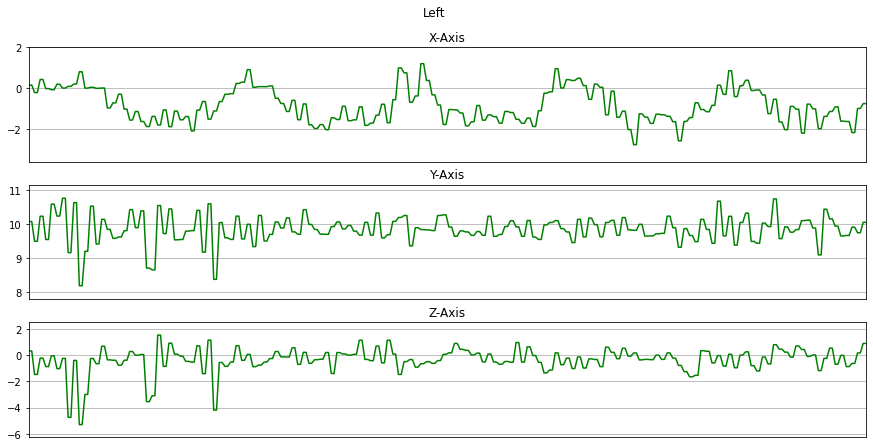

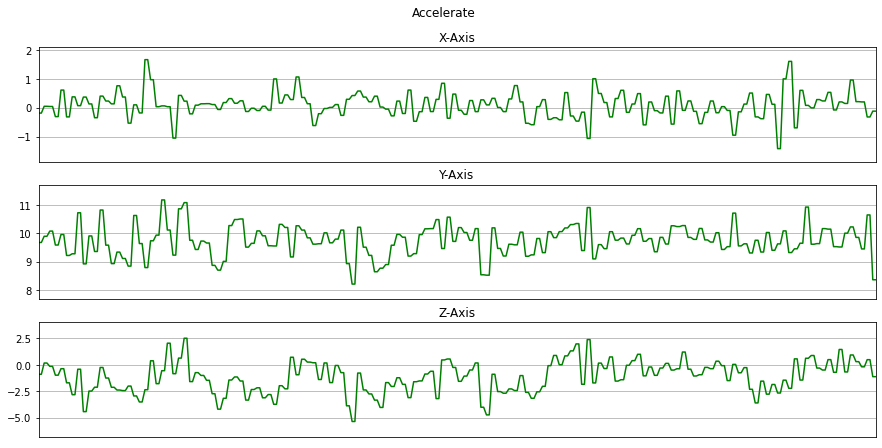

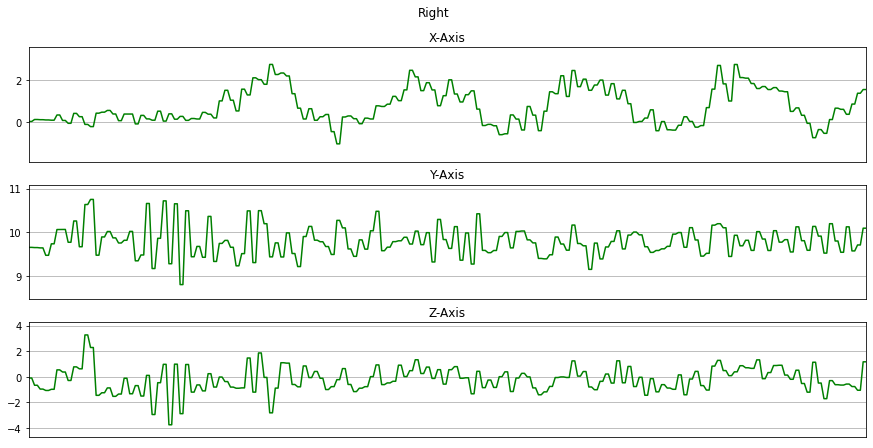

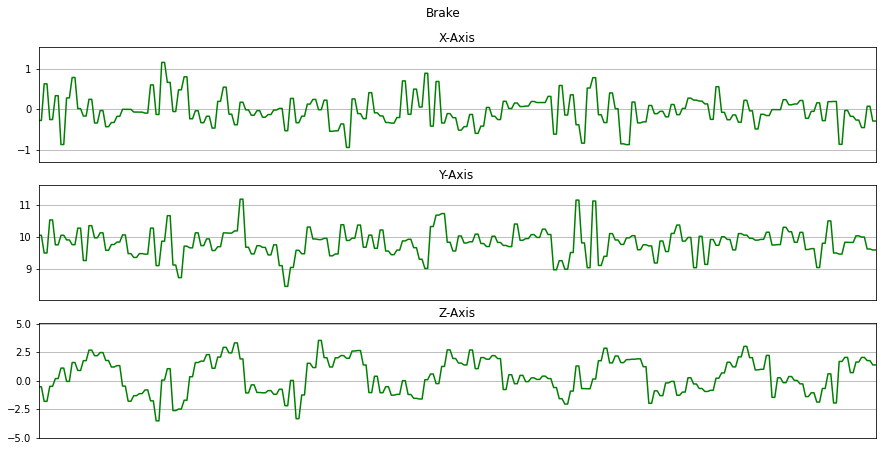

In [55]:
def plot_activity(activity, data):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(15, 7), sharex=True)
    plot_axis(ax0, data['unit'], data['ACCEL_X'], 'X-Axis')
    plot_axis(ax1, data['unit'], data['ACCEL_Y'], 'Y-Axis')
    plot_axis(ax2, data['unit'], data['ACCEL_Z'], 'Z-Axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_axis(ax, x, y, title):
    ax.plot(x, y, 'g')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

for activity in activities:
    data_for_plot = data[(data['ACTIVITY'] == activity)][:Fs*30]
    plot_activity(activity, data_for_plot)

## Balancing data

In [56]:
data['ACTIVITY'].value_counts()

Left          1692
Accelerate    1668
Right         1658
Brake         1430
Name: ACTIVITY, dtype: int64

In [57]:
Left = data[data['ACTIVITY']=='Left'].head(1430).copy()     ##copy data until 1430 and put in variable Left
Accelerate = data[data['ACTIVITY']=='Accelerate'].head(1430).copy()
Right= data[data['ACTIVITY']=='Right'].head(1430).copy()
Brake = data[data['ACTIVITY']=='Brake'].copy()

balanced_data = pd.DataFrame()
balanced_data = balanced_data.append([Left, Accelerate ,Right, Brake])     #append the variables to a panda dataframe
balanced_data.shape

(5720, 10)

In [58]:
balanced_data['ACTIVITY'].value_counts()

Accelerate    1430
Right         1430
Left          1430
Brake         1430
Name: ACTIVITY, dtype: int64

In [59]:
Fs = 10 #10 samples per second
activities = balanced_data['ACTIVITY'].value_counts().index # need to put .index() if want to plot
activities

Index(['Accelerate', 'Right', 'Left', 'Brake'], dtype='object')

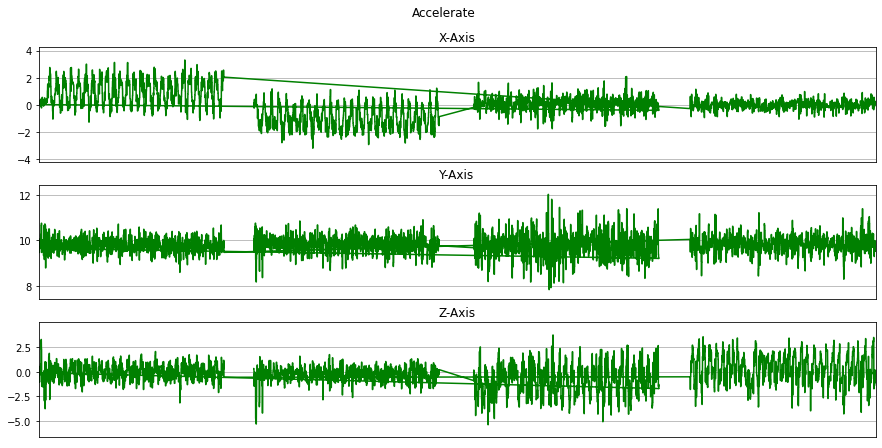

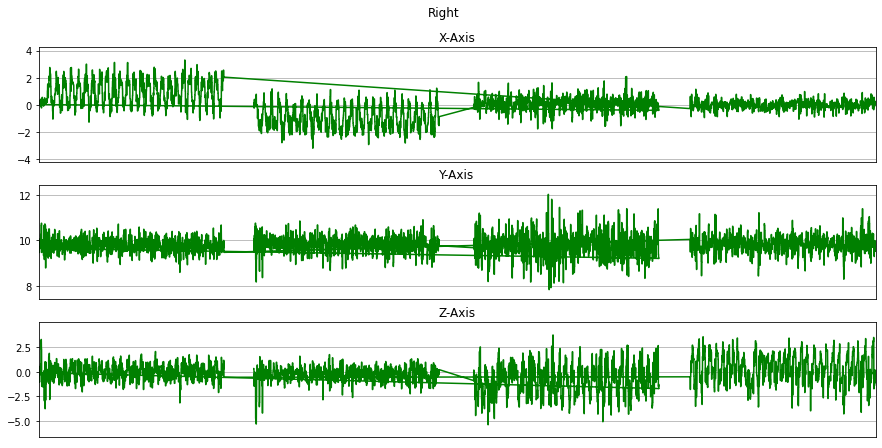

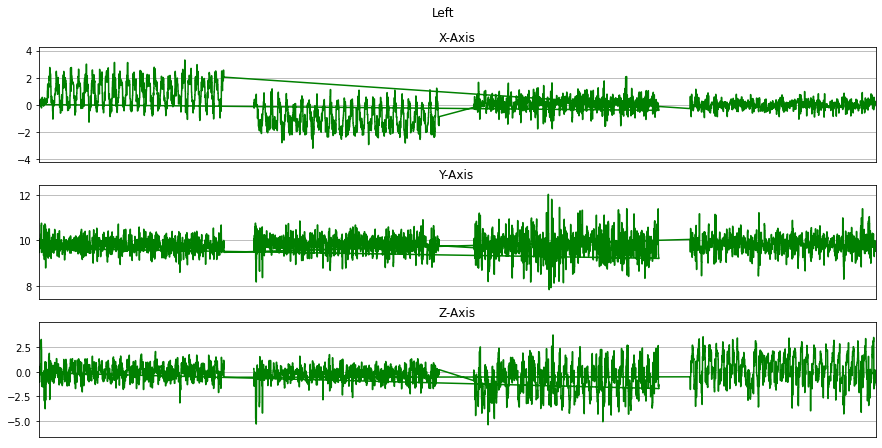

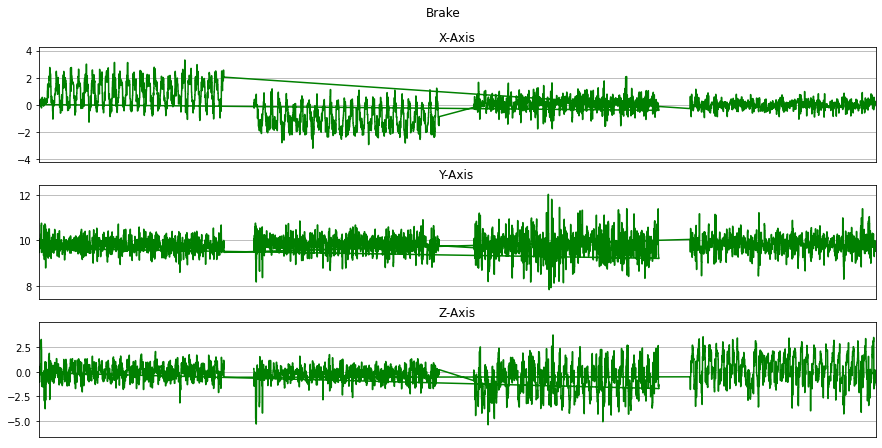

In [60]:
def plot_activity(activity, data):
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(15, 7), sharex=True)
    plot_axis(ax0, balanced_data['unit'], balanced_data['ACCEL_X'], 'X-Axis')
    plot_axis(ax1, balanced_data['unit'], balanced_data['ACCEL_Y'], 'Y-Axis')
    plot_axis(ax2, balanced_data['unit'], balanced_data['ACCEL_Z'], 'Z-Axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_axis(ax, x, y, title):
    ax.plot(x, y, 'g')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

for activity in activities:
    data_for_plot = data[(data['ACTIVITY'] == activity)][:Fs*10]
    plot_activity(activity, data_for_plot)

## 5. Labelling data

In [61]:
from sklearn.preprocessing import LabelEncoder  ## categorical labelling module


### 5.1 Using label encoder

In [62]:
label = LabelEncoder()
balanced_data["label"] = label.fit_transform(balanced_data["ACTIVITY"])
balanced_data.head()

,unit,TIME,ACCEL_X,ACCEL_Y,ACCEL_Z,GYRO_X,GYRO_Y,GYRO_Z,CURRENT_SPEED,ACTIVITY,label
1658,1659,09:59:59,0.134075,10.070312,0.318429,0.002520,0.001222,-0.003054,0.0,Left,2
1659,1660,09:59:59,0.134075,10.070312,0.318429,0.002520,0.001222,-0.003054,0.0,Left,2
1660,1661,10:00:00,-0.232238,9.488521,-1.472434,0.001298,0.000611,-0.000611,0.0,Left,2
1661,1662,10:00:00,-0.232238,9.488521,-1.472434,0.001298,0.000611,-0.000611,0.0,Left,2
1662,1663,10:00:00,0.407014,10.225935,-0.229843,0.002520,0.001833,-0.001833,0.0,Left,2


In [63]:
label.classes_

array(['Accelerate', 'Brake', 'Left', 'Right'], dtype=object)

In [64]:
balanced_data.tail()

,unit,TIME,ACCEL_X,ACCEL_Y,ACCEL_Z,GYRO_X,GYRO_Y,GYRO_Z,CURRENT_SPEED,ACTIVITY,label
6443,6444,10:18:39,0.251391,9.988909,0.172383,0.010461,0.000611,0.000000,0.0,Brake,1
6444,6445,10:18:39,0.263362,9.890746,-0.387861,-0.009697,0.000000,-0.000611,0.0,Brake,1
6445,6446,10:18:39,0.263362,9.890746,-0.387861,-0.009697,0.000000,-0.000611,0.0,Brake,1
6446,6447,10:18:39,0.014365,9.522039,-1.103727,0.004963,0.000611,0.000000,0.0,Brake,1
6447,6448,10:18:39,0.014365,9.522039,-1.103727,0.004963,0.000611,0.000000,0.0,Brake,1


## 6. Standardization (make the model handle lower numbers)

In [65]:
X = balanced_data[['ACCEL_X','ACCEL_Y', 'ACCEL_Z', 'GYRO_X', 'GYRO_Y', 'GYRO_Z']]
y = balanced_data['label']

In [66]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
# NEED TO FOLLOW ORDER IN TABLE EXACTLY!!

scaled_X = pd.DataFrame(data = X, columns = ['ACCEL_X','ACCEL_Y', 'ACCEL_Z', 'GYRO_X', 'GYRO_Y', 'GYRO_Z'])
scaled_X['label']= y.values

scaled_X.head()

,ACCEL_X,ACCEL_Y,ACCEL_Z,GYRO_X,GYRO_Y,GYRO_Z,label
0,0.125149,0.613610,0.437827,0.365755,0.005934,-0.075270,2
1,0.125149,0.613610,0.437827,0.365755,0.005934,-0.075270,2
2,-0.247446,-0.735273,-0.964953,0.296456,0.003637,0.027559,2
3,-0.247446,-0.735273,-0.964953,0.296456,0.003637,0.027559,2
4,0.402769,0.974423,0.008366,0.365755,0.008232,-0.023856,2


## 7. Frame Preparation

In [67]:
import scipy.stats as stats

In [68]:
Fs = 12 # 12 samples per second
frame_size = Fs*4  # 4seconds  in one frame=48 --> frame_size = (48,6)
hop_size = Fs*2  #2 overlap  hop_size = 24 overlap points

In [69]:
def get_frames(df, frame_size, hop_size): ## Need to follow order of columns EXACTLY

    N_FEATURES = 6 # 6 features, 3 for accelerometer and 3 for gyro

    frames = []
    labels = []
    for i in range(0, len(df) - frame_size, hop_size):
        gx = df['ACCEL_X'].values[i: i + frame_size] ## 0-4, 4-8, 8+12
        gy = df['ACCEL_Y'].values[i: i + frame_size]
        gz = df['ACCEL_Z'].values[i: i + frame_size]
        x = df['GYRO_X'].values[i: i + frame_size]
        y = df['GYRO_Y'].values[i: i + frame_size]
        z = df['GYRO_Z'].values[i: i + frame_size]
       
        
        # Retrieve the most often used label in this segment
        label = stats.mode(df['label'][i: i + frame_size])[0][0]
        frames.append([x, y, z, gx, gy, gz])
        labels.append(label)

    # Bring the segments into a better shape
    frames = np.asarray(frames).reshape(-1, frame_size, N_FEATURES)
    labels = np.asarray(labels)

    return frames, labels

X, y = get_frames(scaled_X, frame_size, hop_size)

X.shape, y.shape

((237, 48, 6), (237,))

#### (237*4)/24 = 238.33  -frames

## 8. Splitting data (80% training 20% testing)

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)
X_train.shape, X_test.shape 

((189, 48, 6), (48, 48, 6))

Training = 189,
Testing = 48,
Frame size = 48,
Hop size = 24

In [71]:
X_train[0].shape, X_test[0].shape

((48, 6), (48, 6))

((48,6),(48,6)) <- 2Dimensional data

in one frame, have 48 data points, with 6 features, and will hop with overlap 24

- 1D TENSOR -> ([1,3,4])

- 2D TENSOR -> have 2 axis
             ([[1, 4, 7],
              [2, 5, 8],
              [3, 6, 9]])  in our condition, 48 rows 4 columns

In [72]:
#X_train = X_train.reshape(113, 60, 6)
#X_test = X_test.reshape(29,60,6)

In [73]:
X_train[0]


array([[-0.88163774, -0.88163774, -1.05488668, -1.05488668, -1.60928365,
        -1.60928365],
       [-1.02023696, -1.02023696,  1.47454925,  1.47454925,  0.60830401,
         0.60830401],
       [-0.50048982, -0.50048982,  0.98945189,  0.98945189, -0.67373887,
        -0.67373887],
       [ 0.05390711,  0.05390711, -0.50048982, -0.50048982, -1.08953652,
        -1.08953652],
       [-0.3618906 , -0.3618906 , -0.22329134, -0.22329134, -1.08953652,
        -1.08953652],
       [ 0.85085267,  0.85085267, -0.5351396 , -0.5351396 , -1.64393349,
        -1.64393349],
       [ 0.33110556,  0.33110556,  0.19250633,  0.19250633,  0.01925729,
         0.01925729],
       [-0.39654038, -0.39654038,  0.53900441,  0.53900441,  0.19250633,
         0.19250633],
       [-2.3348752 , -2.3348752 , -2.34865802, -2.34865802, -2.39460143,
        -2.39460143],
       [-2.3302807 , -2.3302807 , -2.09597003, -2.09597003, -1.79044734,
        -1.79044734],
       [-1.24142532, -1.24142532, -1.03927491, -1.

## 9. Creating 1D CNN

In [74]:
model = Sequential()

# model.add(type(filter, (kernel,kernel), activation = .... , input_shape))
model.add(Conv1D(32, kernel_size =3 , activation = 'relu', input_shape = X_train[0].shape))
model.add(MaxPool1D(pool_size=2))
model.add(Conv1D(64, kernel_size =3 , activation = 'relu'))
model.add(MaxPool1D(pool_size=2))

model.add(Dropout(0.8))

model.add(Flatten())         ## Flatten 3D tensor to 1D
model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))   ## 1D
#model.summary()

## 9.1 Fitting model

In [75]:
model.compile(optimizer=Adam(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(X_train, y_train, epochs =100 , validation_data=(X_test, y_test), verbose=1)


Epoch 1/100
6/6 [==============================] - 1s 43ms/step - loss: 2.1889 - accuracy: 0.2201 - val_loss: 1.2760 - val_accuracy: 0.4583
Epoch 2/100
6/6 [==============================] - 0s 9ms/step - loss: 1.6307 - accuracy: 0.3008 - val_loss: 1.2072 - val_accuracy: 0.7083
Epoch 3/100
6/6 [==============================] - 0s 9ms/step - loss: 1.3454 - accuracy: 0.3762 - val_loss: 1.1557 - val_accuracy: 0.7500
Epoch 4/100
6/6 [==============================] - 0s 10ms/step - loss: 1.2928 - accuracy: 0.3979 - val_loss: 1.0945 - val_accuracy: 0.7917
Epoch 5/100
6/6 [==============================] - 0s 10ms/step - loss: 1.1473 - accuracy: 0.4995 - val_loss: 1.0110 - val_accuracy: 0.8125
Epoch 6/100
6/6 [==============================] - 0s 10ms/step - loss: 1.1018 - accuracy: 0.5400 - val_loss: 0.9114 - val_accuracy: 0.8125
Epoch 7/100
6/6 [==============================] - 0s 9ms/step - loss: 1.0009 - accuracy: 0.5790 - val_loss: 0.8078 - val_accuracy: 0.8125
Epoch 8/100
6/6 [======

6/6 [==============================] - 0s 9ms/step - loss: 0.2703 - accuracy: 0.9439 - val_loss: 0.1505 - val_accuracy: 0.9167
Epoch 60/100
6/6 [==============================] - 0s 9ms/step - loss: 0.2868 - accuracy: 0.8925 - val_loss: 0.1493 - val_accuracy: 0.9167
Epoch 61/100
6/6 [==============================] - 0s 9ms/step - loss: 0.2511 - accuracy: 0.9248 - val_loss: 0.1546 - val_accuracy: 0.9167
Epoch 62/100
6/6 [==============================] - 0s 9ms/step - loss: 0.1802 - accuracy: 0.9354 - val_loss: 0.1580 - val_accuracy: 0.9167
Epoch 63/100
6/6 [==============================] - 0s 9ms/step - loss: 0.1929 - accuracy: 0.9328 - val_loss: 0.1505 - val_accuracy: 0.9167
Epoch 64/100
6/6 [==============================] - 0s 9ms/step - loss: 0.2114 - accuracy: 0.9279 - val_loss: 0.1353 - val_accuracy: 0.9375
Epoch 65/100
6/6 [==============================] - 0s 9ms/step - loss: 0.2725 - accuracy: 0.9032 - val_loss: 0.1359 - val_accuracy: 0.9375
Epoch 66/100
6/6 [===============

In [76]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=1)
print('Test accuracy:', test_acc)


2/2 [==============================] - 0s 2ms/step - loss: 0.1312 - accuracy: 0.9583
Test accuracy: 0.9583333134651184


In [77]:
test_loss, test_acc = model.evaluate(X_test,  y_test)
print(test_loss, test_acc)

2/2 [==============================] - 0s 2ms/step - loss: 0.1312 - accuracy: 0.9583
0.1312239021062851 0.9583333134651184


## 10 Result Visualisation

### 10.1 Learning Curves

In [78]:
def plot_learningCurve(history, epochs):
  # Plot training & validation accuracy values
  epoch_range = range(1, epochs+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Model accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range, history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='upper left')
  plt.show()

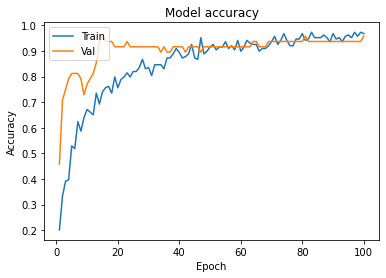

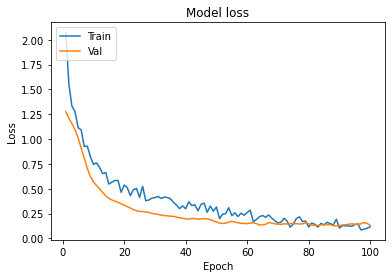

In [79]:
plot_learningCurve(history,100)

### 10.2 Confusion Matrix

In [80]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
y_pred = np.argmax(model.predict(X_test), axis =-1)

(<Figure size 432x288 with 1 Axes>,
 <AxesSubplot:xlabel='predicted label', ylabel='true label'>)

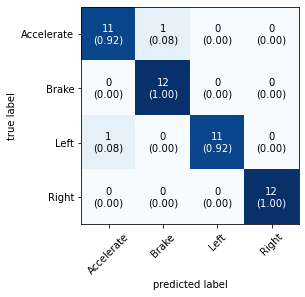

In [81]:
mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=mat, class_names = label.classes_, show_normed = True)